## **Installing pyspark**

In [2]:
!pip install pyspark #installing pyspark 3.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 53.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=e4be83c170d4605908ef1e88eac89162bfb91e458cb090387636f9400620be95
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


## **Installing required JDK**

In [1]:
!apt install openjdk-8-jdk-headless -qq

The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 27 not upgraded.
Need to get 36.6 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u342-b07-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u342-b07-0ubuntu1~18.04) ...
Selecting previously unselected package openjdk-8-

## **Setting Up the enviornment**

In [12]:
import os #you can configure the size of the Spark driver, and the size and number of the executors
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## **Importing Spark Libraries**

In [13]:
import pyspark #importing the important spark libraries
from pyspark import SparkConf #Used to set various Spark parameters as key-value pairs
from pyspark.sql import SparkSession # The entry point to programming Spark with the Dataset and DataFrame API.

## **Creating a Session** 
**if new o.w. it will start the old Session**

In [16]:
#The entry point into all functionality in Spark is the SparkSession class. To create a basic SparkSession, just use SparkSession.builder
spark = SparkSession \
      .builder \
      .appName("PySpark_(2)")\
      .getOrCreate()

## **Getting the Data from Google Drive**

In [6]:
#To use file from cloud (google drive)
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fileDownloaded = drive.CreateFile({'id':'17mjMe3V0UbDNG_lC4Se2hE6j4qGvqTit'})
fileDownloaded.GetContentFile('mini_spark_event_data.json')

## **Importing Libraries relevant for our ML Algorithms**

In [8]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
#ParamGridBuilder -Sets the given parameters in this grid to fixed values. Accepts either a parameter dictionary or a list of (parameter, value) pairs.

## **Loading The Dataset**

In [9]:
df = "mini_spark_event_data.json"
df = spark.read.json(df)

## **EDA**

In [10]:
df.printSchema() #printing the schema (contents) of the table

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [17]:
#It is basically showing the datatype of each columns
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [18]:
print(f"No. of rows {df.count()}") #it is showing the no. of rows in this dataframe

No. of rows 286500


In [19]:
df.show(n=1) #it is showing the rows in perfect format

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [20]:
df.describe().show() #describe and show

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

## **Dataset Cleaning**

In [21]:
# Cleaning the Dataset
df = df.drop(*['artist','song','firstName', 'lastName', 'id_copy']) # dropping some irrelevant columns
df = df.dropna(how = 'any', subset = ['userId', 'sessionId']) # droppping some potential NA values
df = df.filter(df.userId!='').orderBy(["userId", "ts"], ascending=[True, True]) # filtering out the invalid Ids
df = df.withColumn("userId", df["userId"].cast(IntegerType())) #adding a new column userID of int type


## **Data Processing**

In [22]:
#Defining the churn
#These are the customers landing on the cancellation confirmation page

cancelation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0,
                   IntegerType())
df = df.withColumn("churn", cancelation("page"))
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding,
                                                   Window.unboundedFollowing)
df = df.withColumn("churn", Fsum("churn").over(window))

In [23]:
##Some new columns were made in this step to make the data exploration easier,
# the Feature engineering step comes later
# Making the level_shift Column
# This column tells us how many times did the customer switched
# from paid to free service
window1 = Window.partitionBy().orderBy(["userId", "ts"]) #creates a WindowSpec with the partitioning defined
df = df.withColumn("level_shift", (df.level!=F.lag(df.level).over(window1)) | 
                   (df.userId!=F.lag(df.userId).over(window1)))
df=df.fillna({'level_shift':0})
df= df.withColumn("level_shift", F.when(df["level_shift"]==False, 0).otherwise(1))

In [24]:
# Making the last_ts column
# This column will help us to select only records that happened in the
# last 2 weeks of customer activity
# The idea is that customer behavior should be different shortly before
# the churn happened
df= df.withColumn("ts", df.ts/1000) # trimming the last three zeros from the UNIX time (miliseconds)
df= df.withColumn("registration", df.registration/1000)

In [25]:
window2 = Window.partitionBy("userId")
df= df.withColumn("last_ts", F.max('ts').over(window2)) #adding a col last_ts 
df=df.filter(df.last_ts - df.ts < 1300000) # approx no of sec in a 2 weeks

In [26]:
# Making the Columns: pages_per_session, diff_time
# pages_per_session is number of pages per session
# diff_time is a number of days since a specific page was visited
window3 = Window.partitionBy(["userId", "sessionId"])
df= df.withColumn("pages_per_session", F.max('ItemInSession').over(window3))
df = df.withColumn("ts_time",F.to_timestamp(df.ts)) #  unix to datetime
df = df.withColumn("last_ts_time",F.to_timestamp(df.last_ts))# unix to datetime

In [27]:
df = df.withColumn("diff_time",F.datediff(df.last_ts_time, df.ts_time))
  # how many days ago was the page visited
df=df.orderBy(["userId", "ts"], ascending=[True, True])
#Creating a Temporary View and Run Queries
#The code below will create a temporary view on which we can run SQL queries
df.createOrReplaceTempView('data') # Create a Temp Table to be used for SQL queries

In [28]:
#Data Preview
df.limit(2).toPandas() 

,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,...,ts,userAgent,userId,churn,level_shift,last_ts,pages_per_session,ts_time,last_ts_time,diff_time
0,Logged In,F,0,250.82730,paid,"Raleigh, NC",PUT,NextSong,1.536800e+09,1639,...,1.542150e+09,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1.542839e+09,192,2018-11-13 22:51:43,2018-11-21 22:30:04,8
1,Logged In,F,1,148.55791,paid,"Raleigh, NC",PUT,NextSong,1.536800e+09,1639,...,1.542150e+09,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1.542839e+09,192,2018-11-13 22:55:53,2018-11-21 22:30:04,8


In [29]:
# The column "page" seems to be most informative in the whole dataset
# It shows which pages of the service were visited by users, timestamp is also provided
# This column can be used to engineer useful features
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|         52|
|    Submit Downgrade|         16|
|         Thumbs Down|        917|
|                Home|       3701|
|           Downgrade|        821|
|         Roll Advert|       1308|
|              Logout|       1201|
|       Save Settings|        126|
|Cancellation Conf...|         52|
|               About|        183|
|            Settings|        607|
|     Add to Playlist|       2380|
|          Add Friend|       1613|
|            NextSong|      85017|
|           Thumbs Up|       4479|
|                Help|        537|
|             Upgrade|        154|
|               Error|         80|
|      Submit Upgrade|         37|
+--------------------+-----------+



In [30]:
df.printSchema() #to print the schema

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- churn: long (nullable = true)
 |-- level_shift: integer (nullable = false)
 |-- last_ts: double (nullable = true)
 |-- pages_per_session: long (nullable = true)
 |-- ts_time: timestamp (nullable = true)
 |-- last_ts_time: timestamp (nullable = true)
 |-- diff_time: integer (nullable = true)



In [31]:
# Investigation if there are differences between churned and non-churned users
# label             - 0 if non_churned, 1 if churned
# song_count        - avg number of songs played by churned/non_churned users
# error             - avg number of errors occuring 
# friends           - avg number of "friends" on thhe application
# playlist_count    - avg number of visits to the Playlist page
# thumbs_up         - avg number of clicking the 'thumbs up'
# thumbs_down       - avg number of clicking the 'thumbs down'
# downgrade         - avg number of visits to the downgrade page
# count_session_dist- avg number of sessions made
# count_diff_time   - avg number of days (in the last two weeks) in which the user used the app
# pages per session - avg numbers of pages (or any activity or changes) per session
# duration          - avg number of days since the user joined (division with 86400 as a proxy of seconds within a day)
# level_shift       - avg number of level changes (free, paid) per customer
# usage_time        - avg total time spent using the app

stats = spark.sql(" WITH prep as( \
                  SELECT userId, \
                  max(churn)  as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
avg(distinct pages_per_session)                                     as pages_per_session, \
(max(ts) - min(registration))/86400                                 as duration, \
sum(level_shift)                                                    as level_shift, \
sum(length)                                                         as usage_time \
FROM data \
GROUP BY userId) \
SELECT label, \
count(label)             as cnt, \
avg(song_count)          as song_count, \
avg(error)               as error, \
avg(friends)             as friends, \
avg(playlist_count)      as playlist_count, \
avg(thumbs_up)           as thumbs_up, \
avg(thumbs_down)         as thumbs_down, \
avg(downgrade)           as downgrade, \
avg(count_session_dist)  as count_session_dist, \
avg(count_diff_time)     as count_diff_time, \
avg(pages_per_session)   as pages_per_session, \
avg(duration)            as duration, \
avg (level_shift)        as level_shift, \
avg(usage_time)          as usage_time \
FROM prep \
GROUP BY label")
# We can see that for most dimensions/features there are differences between
# churned and non-churned users
stats.toPandas()

,label,cnt,song_count,error,friends,playlist_count,thumbs_up,thumbs_down,downgrade,count_session_dist,count_diff_time,pages_per_session,duration,level_shift,usage_time
0,0,173,360.803468,0.335260,7.098266,10.017341,19.132948,3.560694,3.358382,4.583815,4.786127,106.386183,86.620619,0.265896,89989.124825
1,1,52,434.576923,0.423077,7.403846,12.442308,22.480769,5.788462,4.615385,5.596154,5.480769,92.803856,57.305993,0.730769,108072.679578


In [32]:
# Feature Enigneering
# Based on the previous analysis, all 14 investigated features will be included. 
# Here I am making a Temp Table which holds all the features.
# The temp table will be used as model input
# All data is aggregated per userId
features = spark.sql("SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
round(avg(distinct pages_per_session),0)                            as pages_per_session, \
round((max(ts) - min(registration))/86400,0)                        as duration, \
round(sum(level_shift),0)                                           as level_shift, \
round(sum(length),0)                                                as usage_time \
FROM data \
GROUP BY userId");
features.createOrReplaceTempView('features');
features=features.na.drop()

In [33]:
#Train test split
#splitting the dataset in 80:20 train test ratio
training, test = features.randomSplit([0.8,0.2])

In [34]:
# Make VectorAssembler - this is a Pypark specific step
# All input features must be in one column before feeding into the model
assembler = VectorAssembler(inputCols=["userId","song_count","error","friends","playlist_count", \
                                       "thumbs_up","thumbs_down","downgrade", "count_session_dist",\
                                       "count_diff_time","pages_per_session", "duration","level_shift",\
                                       "usage_time"], \
                            outputCol="inputFeatures")
#VectorAssembler - A feature transformer that merges multiple columns into a vector column.

In [35]:
scaler = Normalizer(inputCol = "inputFeatures",outputCol="features") #Normalize Data

In [36]:
lr = LogisticRegression() #instanciating the ML algorithms
gbt = GBTClassifier()
rf = RandomForestClassifier()

In [37]:
#ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines.
#Building pipelines
pipeline1 = Pipeline(stages=[assembler, scaler,lr])
pipeline2 = Pipeline(stages=[assembler, scaler,gbt])
pipeline3 = Pipeline(stages=[assembler, scaler,rf])

## **Logistic Regression**

In [38]:
# metric chosen is f1 (we want to catch true positives (churn customers), but
# we do not want to waste money on false positives (investing in retaining 
# non-churn customers, which are loyal anyway)
# Note that Recall might also be justified to use here (if the cost offalse
# positives is low)
paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10])\
.build()

In [39]:
evaluator = MulticlassClassificationEvaluator(metricName="f1") #defining the evaluator

In [40]:
crossval= CrossValidator(estimator=pipeline1,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator , 
                         numFolds=3
                        ) #crossvalidation - this performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets 

In [42]:
cvModel1 = crossval.fit(training) #fitting the training data

In [43]:
evaluator.evaluate(cvModel1.transform(test)) #its basically evaluate the performance of the model

0.746524064171123

## **Gradient Boosted Tree Classifier**

In [44]:
# Specify multiple parameters in the paramgrid, in case you have
# enough processing power 
paramgrid1 =ParamGridBuilder().build()

In [45]:
evaluator=MulticlassClassificationEvaluator(metricName="f1")#defining the evaluator

In [46]:
crossval= CrossValidator(estimator=pipeline2,  
                         estimatorParamMaps=paramgrid1,
                         evaluator=evaluator, 
                         numFolds=3
                        )#crossvalidation - this performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets 

In [47]:
cvModel2 = crossval.fit(training)#fitting the training data

In [48]:
evaluator.evaluate(cvModel2.transform(test))#evaluating the performance of the model

0.7900373599003736

## **Random Forest Classifier**

In [49]:
paramgrid2 = ParamGridBuilder().build()

In [50]:
evaluator=MulticlassClassificationEvaluator(metricName="f1")#its defining the evaluator

In [51]:
crossval = CrossValidator(estimator=pipeline3,
                          estimatorParamMaps=paramgrid2,
                          evaluator=evaluator,
                          numFolds=3
                          ) #crossvalidation - this performs model selection by splitting the dataset into a set of non-overlapping randomly partitioned folds which are used as separate training and test datasets 

In [52]:
cvModel3 = crossval.fit(training)#fitting the training data

In [53]:
evaluator.evaluate(cvModel3.transform(test))#evaluating the performance of the model

0.7132867132867133

In [54]:
predictions=cvModel2.transform(test)

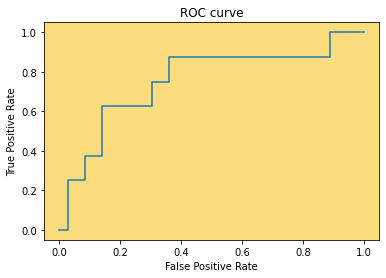

In [55]:
def roc(ax, predictions, labels, title='ROC curve'):
    pp = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    tpr, fpr, _ = roc_curve(labels, pp)
    ax.plot(tpr, fpr)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    
#plt.clf() # to be used for AWS EMR
labels=predictions.toPandas()['label']
fig = plt.figure()
ax = fig.add_subplot(111)
roc(ax, predictions,labels)

 **By seeing the evaluating score it can be infered Random Forest Classifier is the best ML algorithm for analysis this dataset**